## Pythonによる画像解析実例 #6: 出芽酵母位相差像の分節化（100倍対物レンズ）
Cox4-mNGの画像解析における解析事例。  
出芽酵母の100倍位相差像から細胞の輪郭を特定。  
以前試した感触では、ImageJ/FIJIでは効率が良くなかったがPythonではどうなるかを検証

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import skimage
from skimage import io, img_as_float, img_as_ubyte
import imageio
from PIL import Image as pilimage
from IPython.display import display, Image
from skimage.color import rgb2gray
from skimage.util import invert, img_as_ubyte, img_as_uint, img_as_bool
# from cv2_rolling_ball import subtract_background_rolling_ball
from skimage.filters import threshold_isodata
from skimage.segmentation import clear_border
from skimage.morphology import binary_opening
from scipy import ndimage
from tifffile import tifffile as tiff

from skimage.filters import threshold_li
from skimage.morphology import skeletonize
from skimage import exposure
from skimage import restoration

# Jupyter notebookの中で画像を表示させるための関数、読み込んだ画像が16-bitならば画像を8bitに変換するように修正
def show(img_grey):
    if img_grey.dtype == "uint16":
        img_grey = cv2.normalize(img_grey, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    _, buf = cv2.imencode(".jpg", img_grey)
    print(type(buf))
    print(buf.shape)
    display(Image(data = buf.tobytes()))

In [3]:
img0 = tiff.imread("images/yeast_phase_x100.tif")

In [4]:
print("読み込まれた画像の枚数:", len(img0))
print("配列の次元数:", img0.ndim)
print("配列の形状:", img0.shape)
print("要素のデータ型:", img0.dtype)

読み込まれた画像の枚数: 1088
配列の次元数: 2
配列の形状: (1088, 1636)
要素のデータ型: uint8


In [5]:
path = "images/yeast_phase_x100.tif"
with tiff.TiffFile(path) as f: # with構文でファイルを開くと様々なメタデータが抽出できる
    print("ファイル名:",f.filename)
    print("各次元の説明:", f.series[0].axes)
    tags = f.pages[0].tags
    ijmetadata = f.imagej_metadata
lengthunit = ijmetadata["unit"]
xresolution = tags["XResolution"].value[0]/tags["XResolution"].value[1]
yresolution = tags["YResolution"].value[0]/tags["YResolution"].value[1]
print("Unit of length:", lengthunit)
print(f"Resolution in X: {xresolution} pixels per {lengthunit}")
print(f"Resolution in Y: {yresolution} pixels per {lengthunit}")
print(f"Voxel size: {1/xresolution} x {1/yresolution} x 1 {lengthunit}^3")

ファイル名: yeast_phase_x100.tif
各次元の説明: YX
Unit of length: micron
Resolution in X: 11.361111 pixels per micron
Resolution in Y: 11.361111 pixels per micron
Voxel size: 0.0880195607630275 x 0.0880195607630275 x 1 micron^3


<class 'numpy.ndarray'>
(262973,)


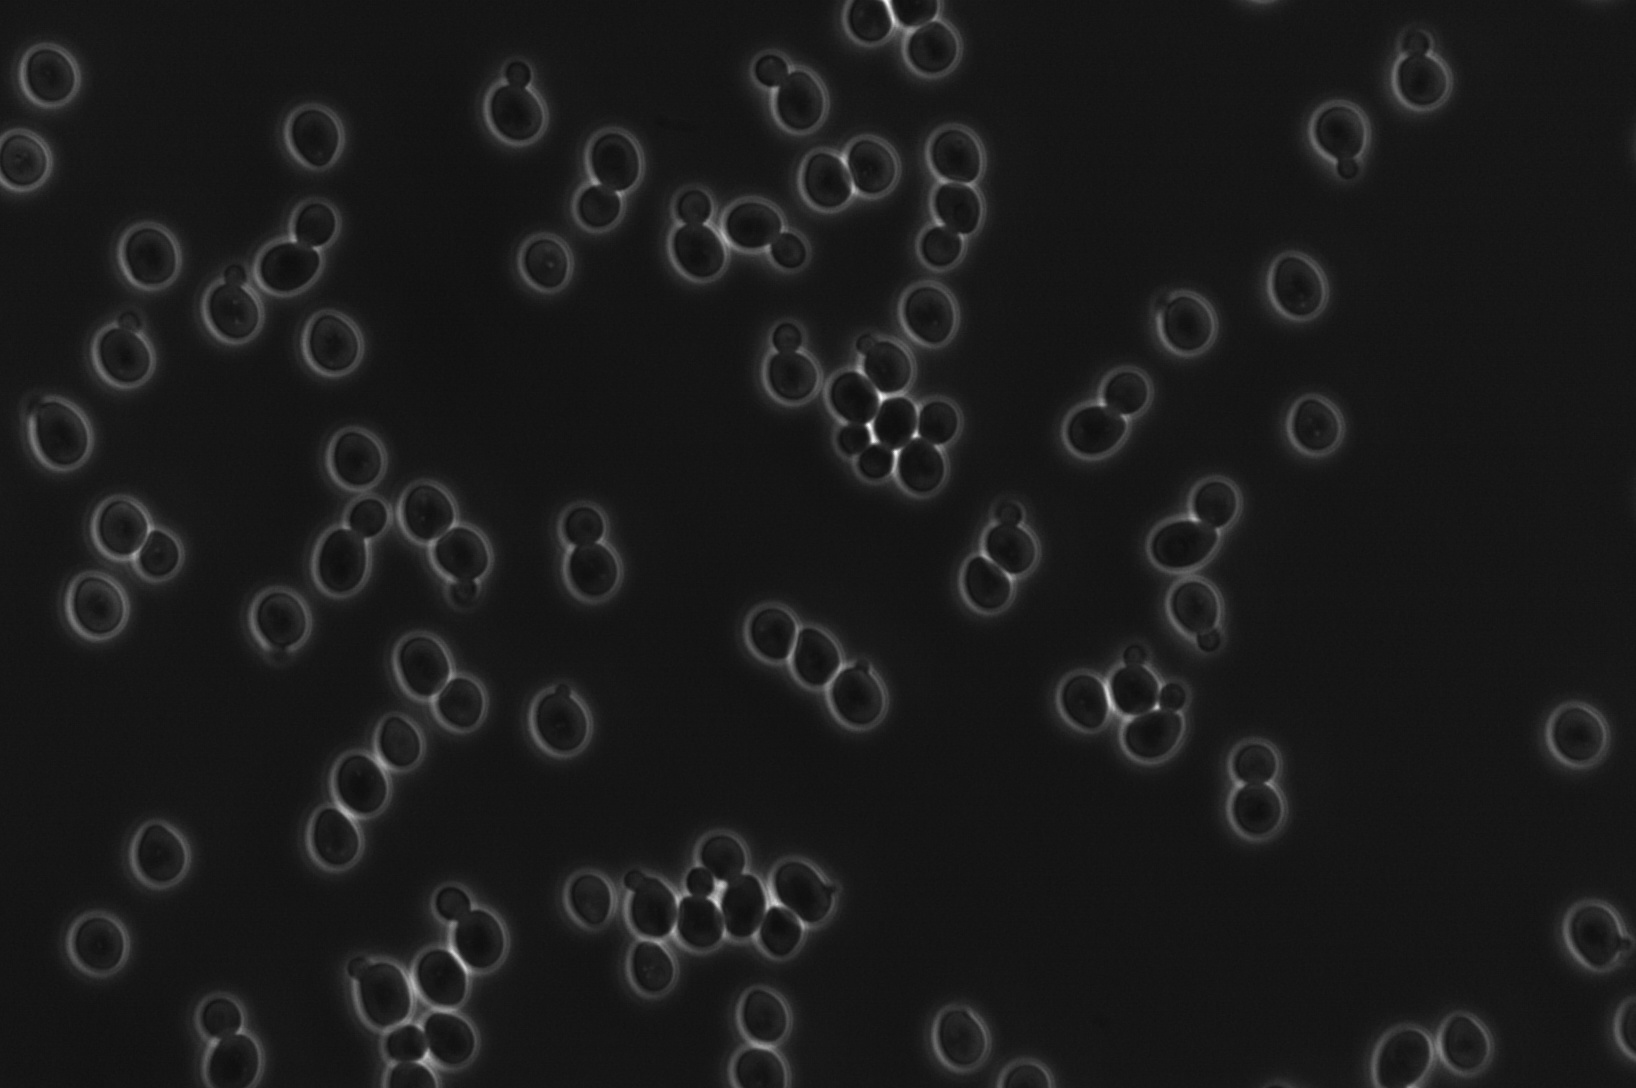

dtype('uint8')

In [11]:
show(img0)
img1.dtype

<class 'numpy.ndarray'>
(151115,)


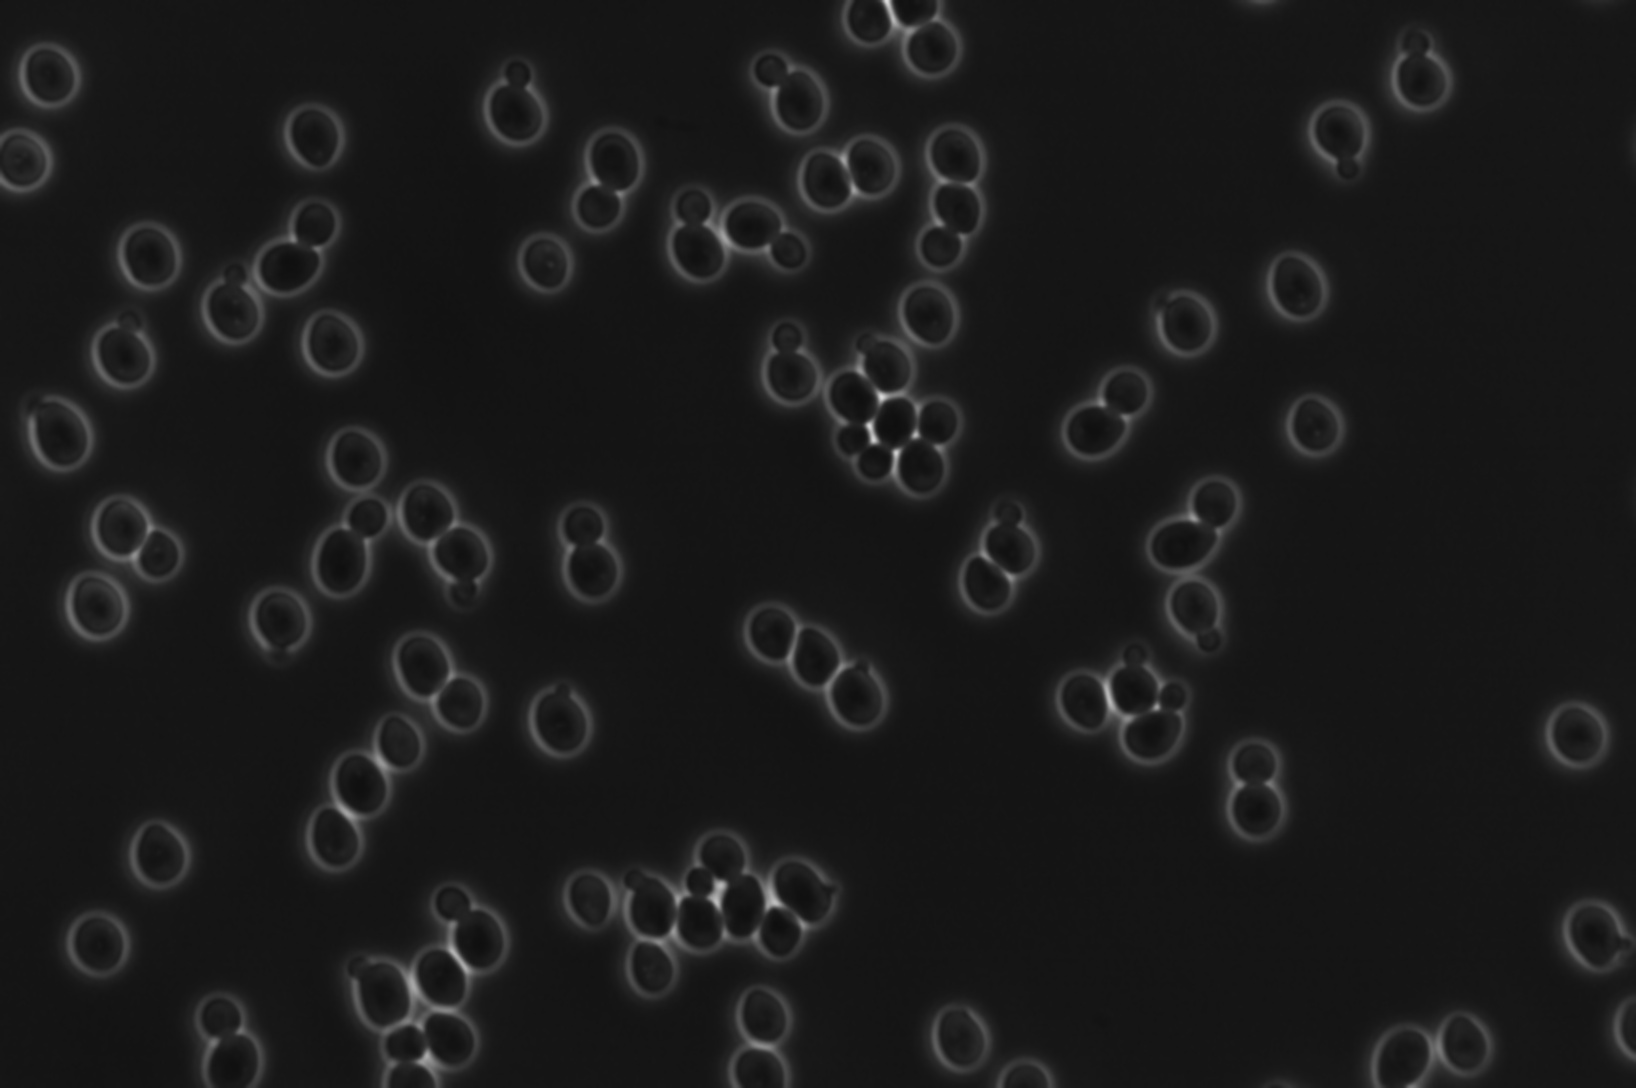

221

In [76]:
# ガウシアンフィルタ（カーネルサイズを自動計算）
gblur = cv2.GaussianBlur(
    img0,    # 入力画像
    (0, 0), # カーネルのサイズを０にしてσの値からカーネルサイズを自動計算
    1.5       # X方向のσの値, Y方向のσを指定しないとXと同じ値になる、60倍では1
    )
show(gblur)
gblur.max()

In [77]:
# rolling background subtraction by skimage
radius = 30 # 60倍では25
background = restoration.rolling_ball(gblur, radius = radius, kernel=None,
                                     nansafe=False, num_threads=None)
filtered = gblur - background

<class 'numpy.ndarray'>
(157453,)


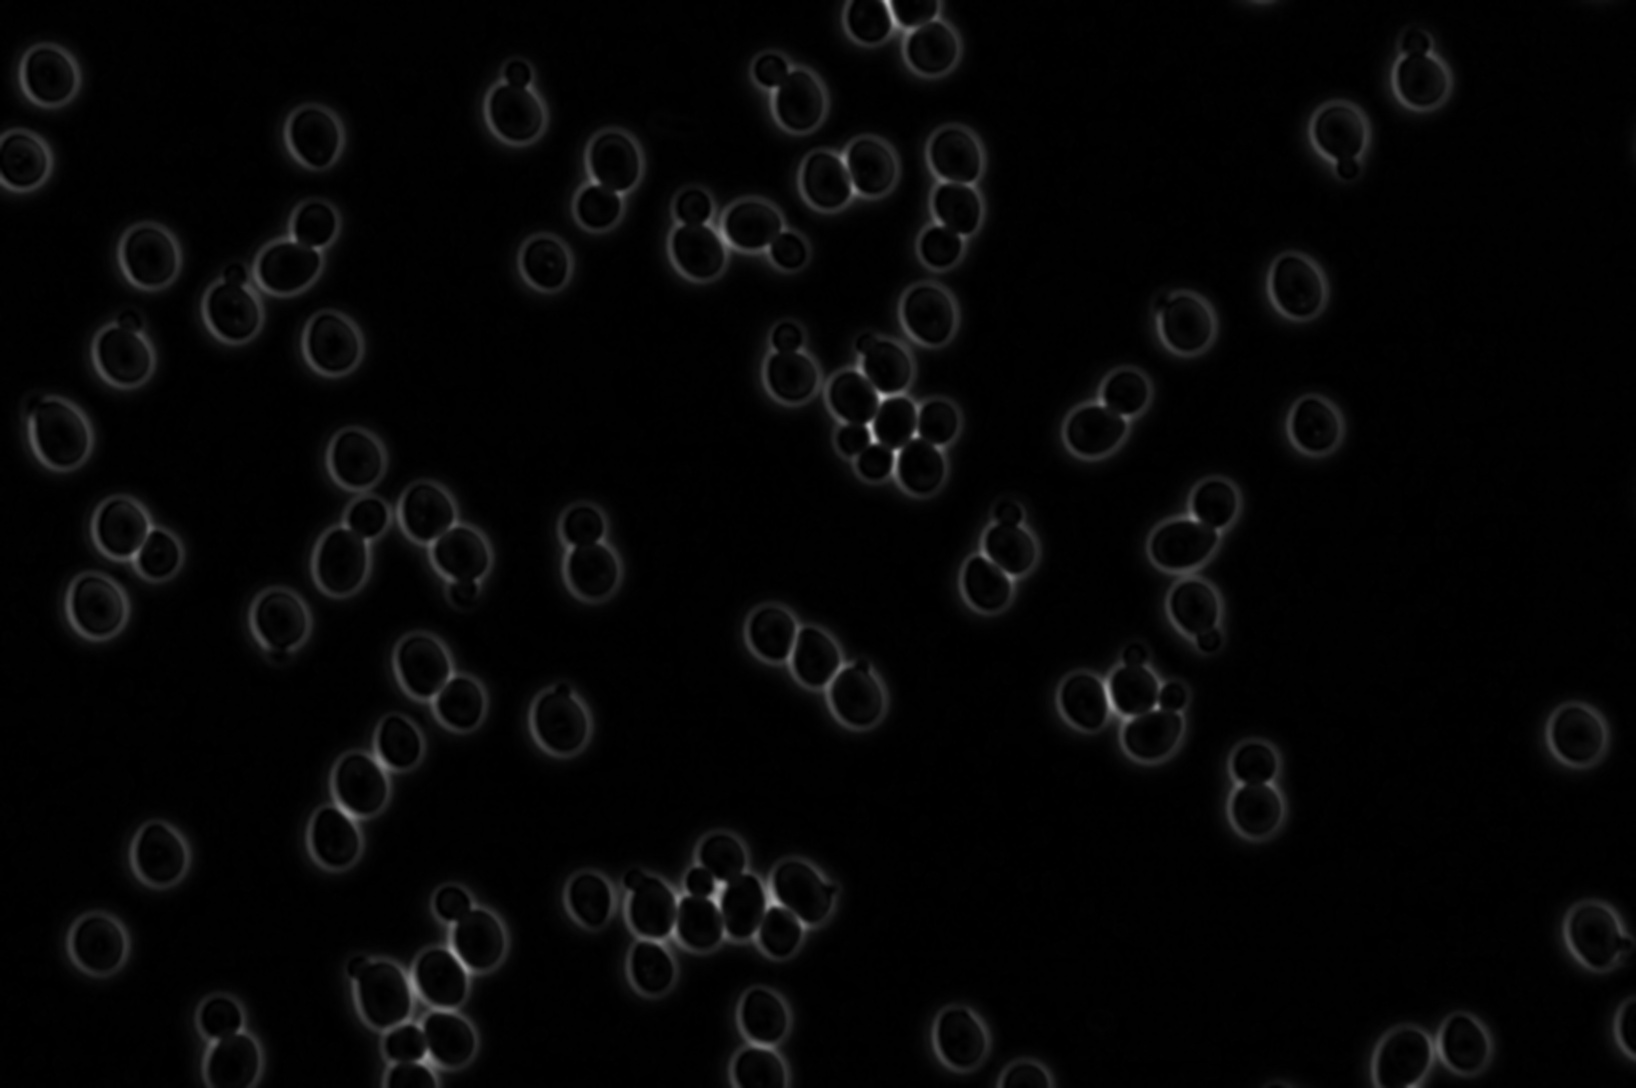

In [78]:
show(filtered)

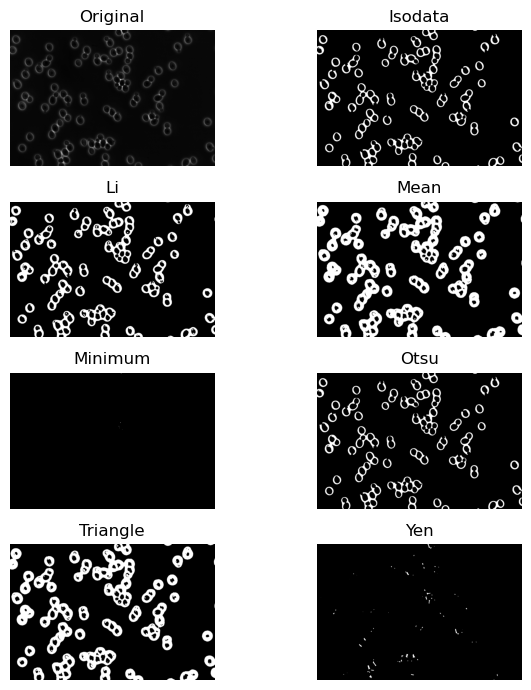

In [79]:
from skimage.filters import try_all_threshold
fig, ax = try_all_threshold(gblur, figsize =(7, 7), verbose = False)
plt.show()

In [80]:
# Auto threshold, Li method
from skimage.filters import threshold_li
thresh = threshold_li(filtered)
mask = np.where(filtered > thresh, 1, 0) # numpyによる2値化処理

<class 'numpy.ndarray'>
(301446,)


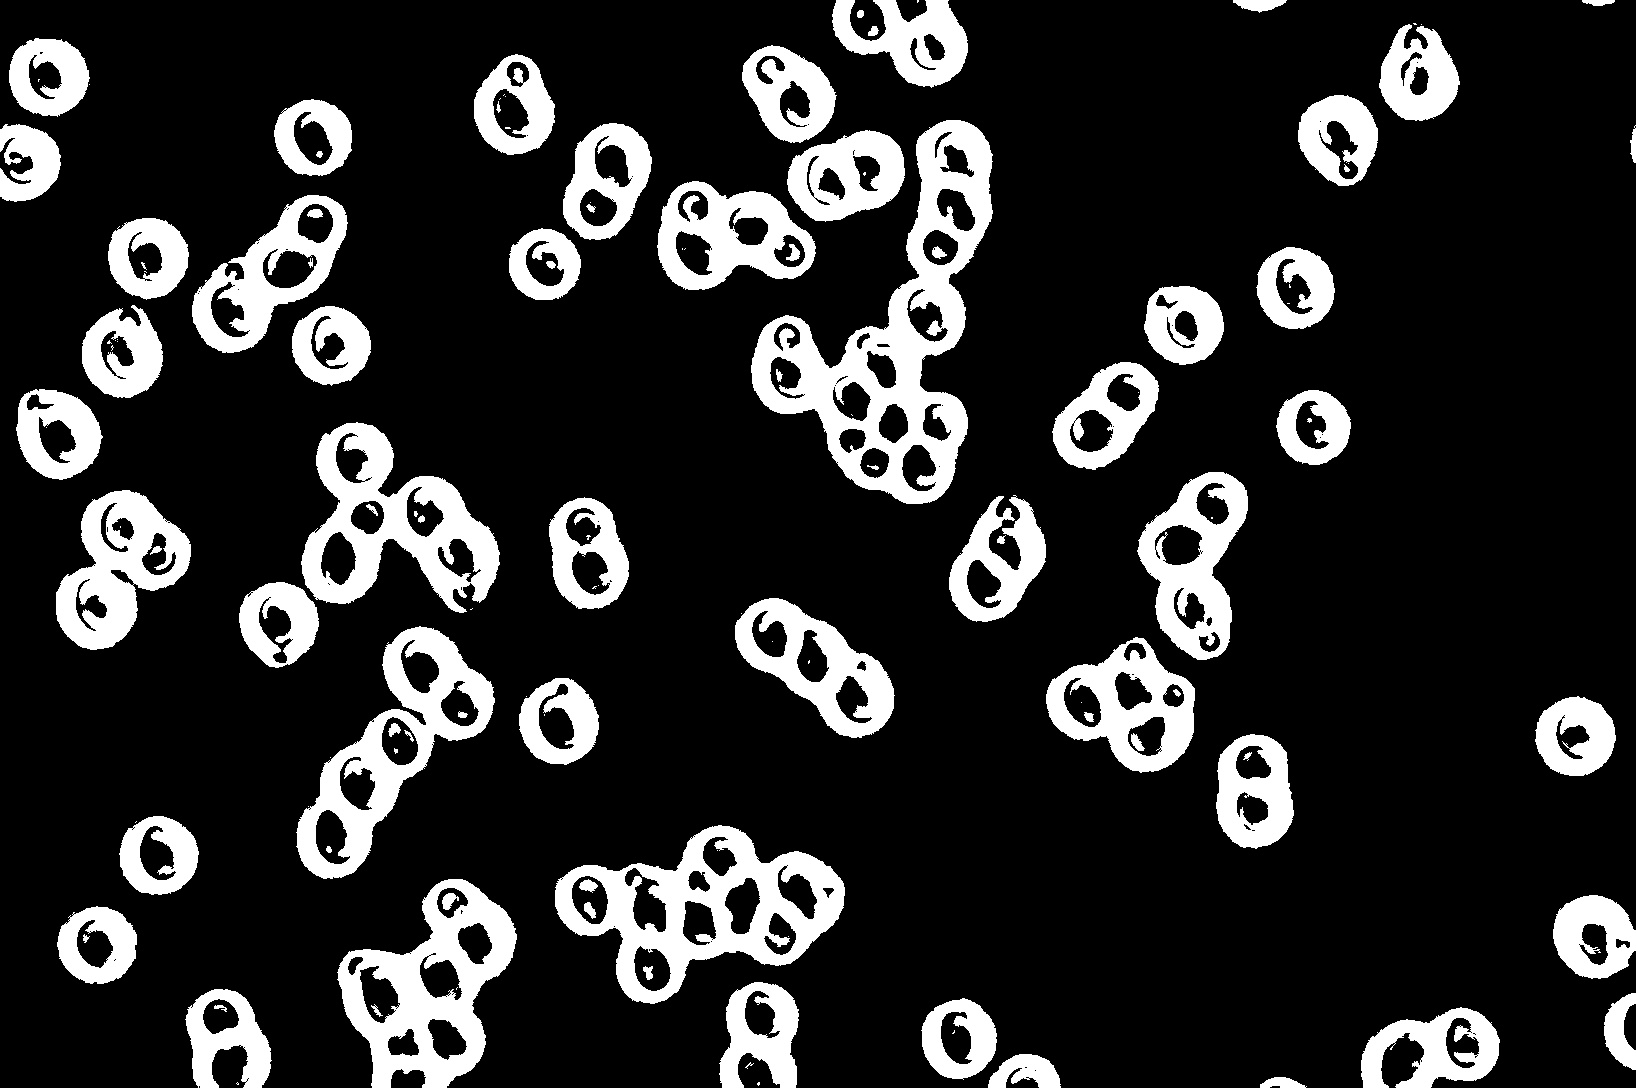

In [81]:
show(mask*255)

<class 'numpy.ndarray'>
(289862,)


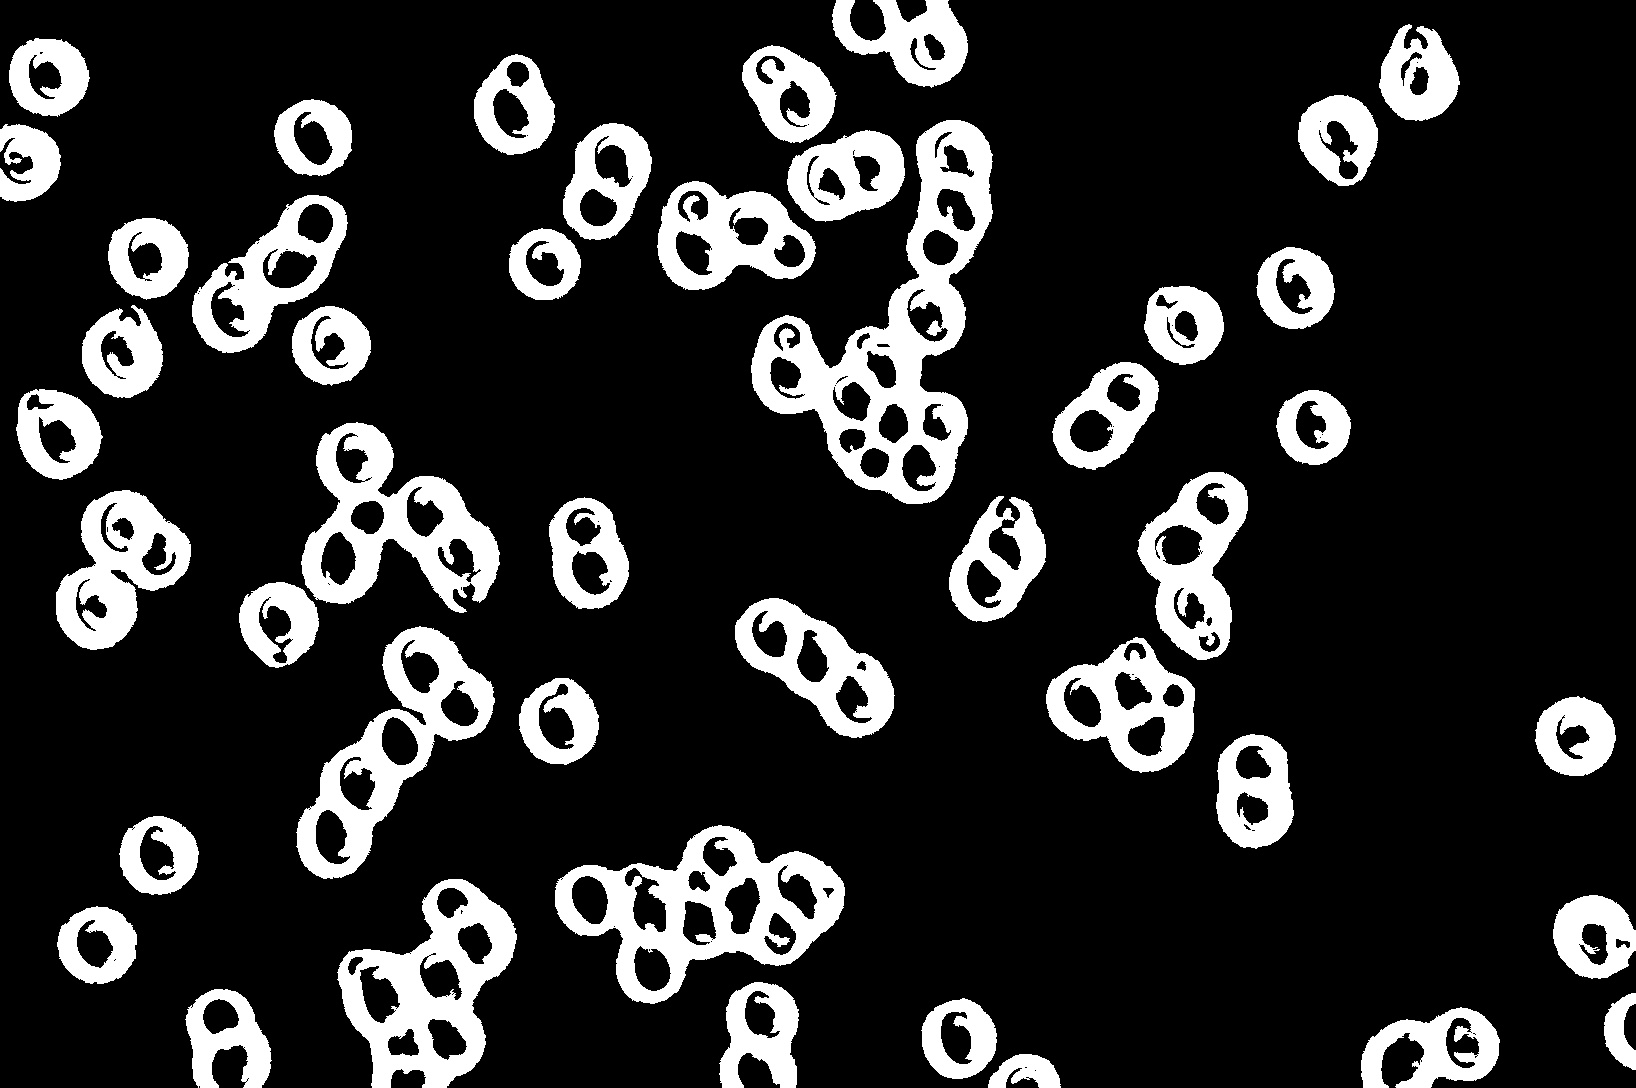

In [82]:
# 小さなブロブを除く
from skimage import io, morphology
arr = mask > 0
cleaned = morphology.remove_small_objects(arr, min_size=500) # x60では256だったのを256*100/60 = 427
cleaned = img_as_ubyte(cleaned)
show(cleaned)

<class 'numpy.ndarray'>
(290018,)


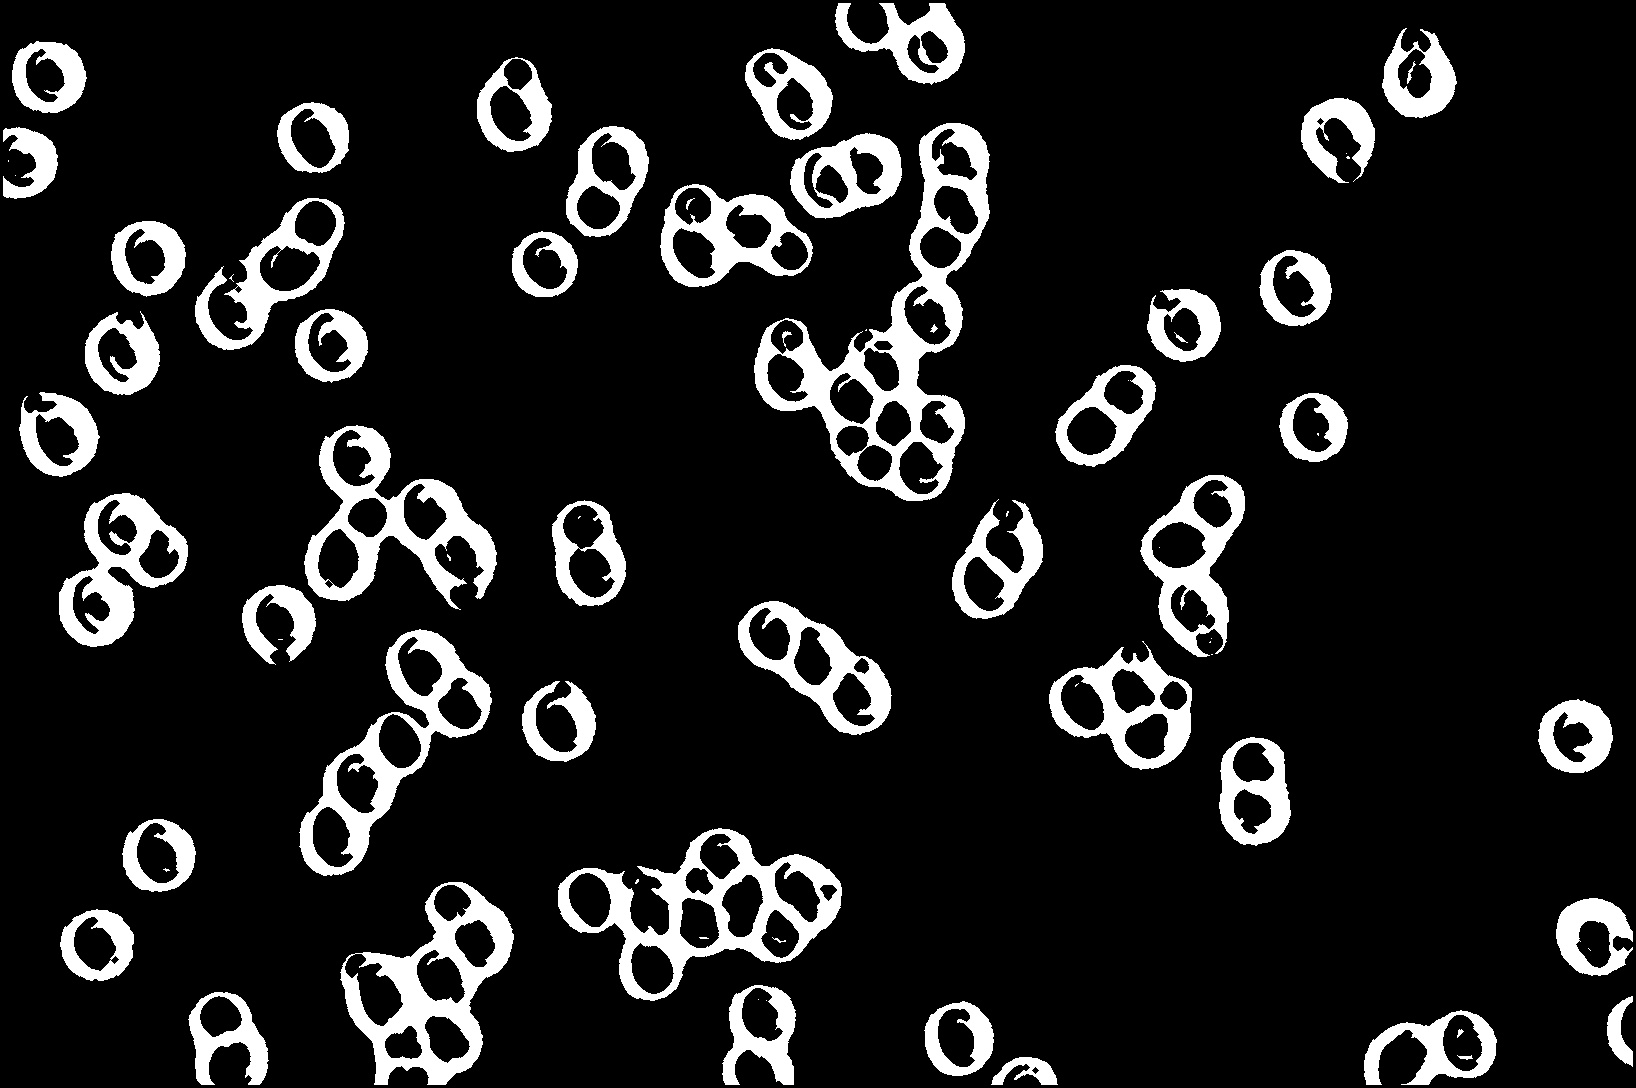

In [84]:
# dilationではなくerosionにする
from scipy import ndimage
erosion = ndimage.binary_erosion(cleaned, iterations= 3).astype(mask.dtype) # 60倍ではinterations = 2だった
show(erosion*255)

<class 'numpy.ndarray'>
(184931,)


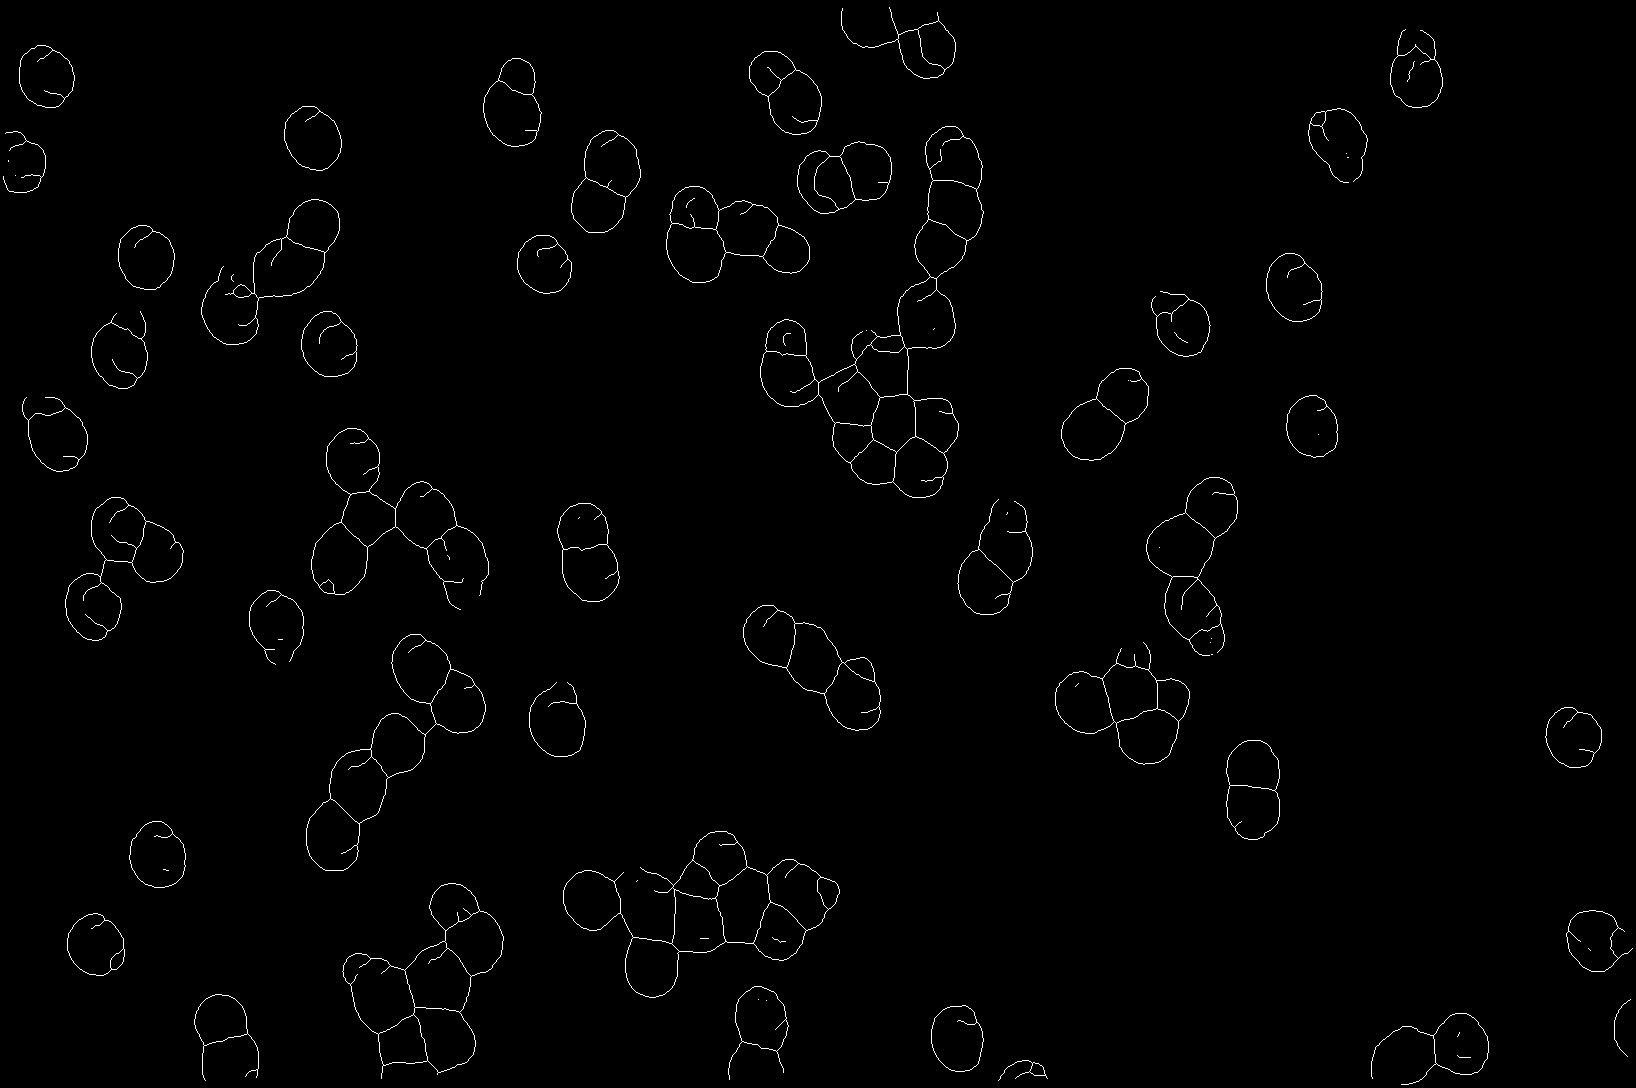

In [85]:
# skeletonize
from skimage.morphology import skeletonize
sk = skeletonize(erosion, method='lee')
show(sk*255)

In [86]:
# Dialate & closing
sk_dia = ndimage.binary_dilation(sk, iterations= 1).astype(sk.dtype) # 60倍ではiterations = 1だった
sk_close = ndimage.binary_closing(sk_dia, iterations=1).astype(sk_dia.dtype) # 60倍ではiterations = 1だった

<class 'numpy.ndarray'>
(221796,)


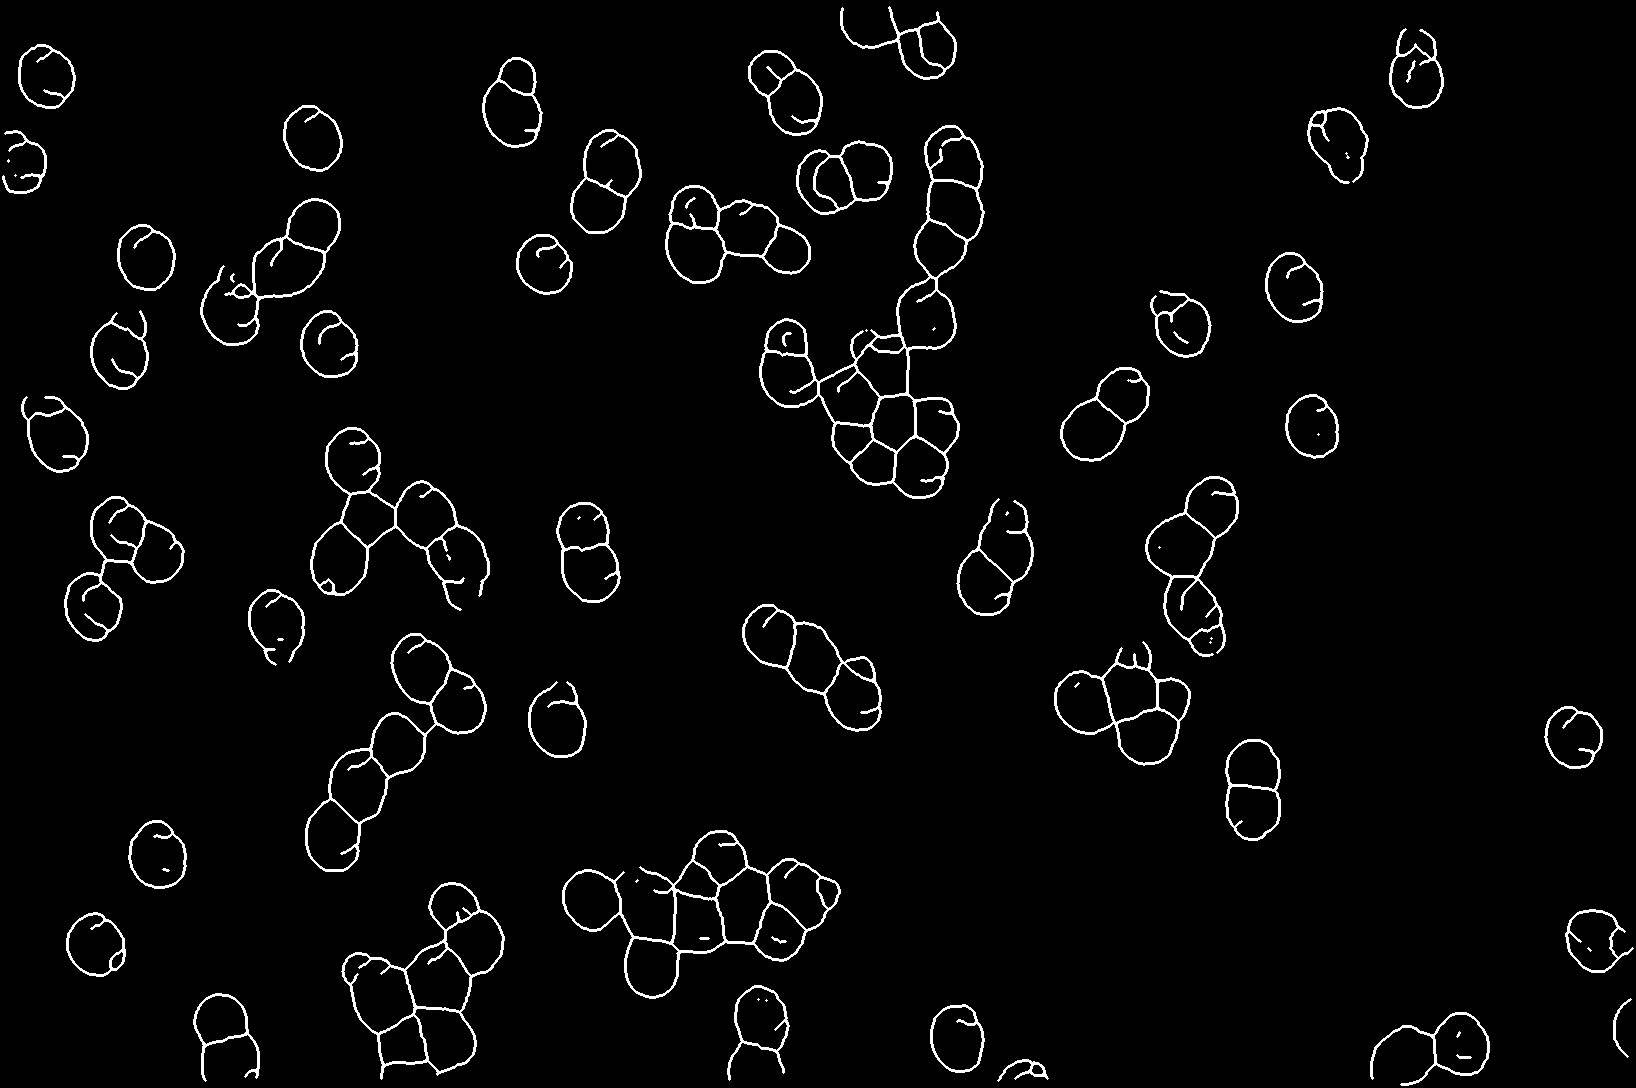

In [87]:
show(sk_close*255)

<class 'numpy.ndarray'>
(155101,)


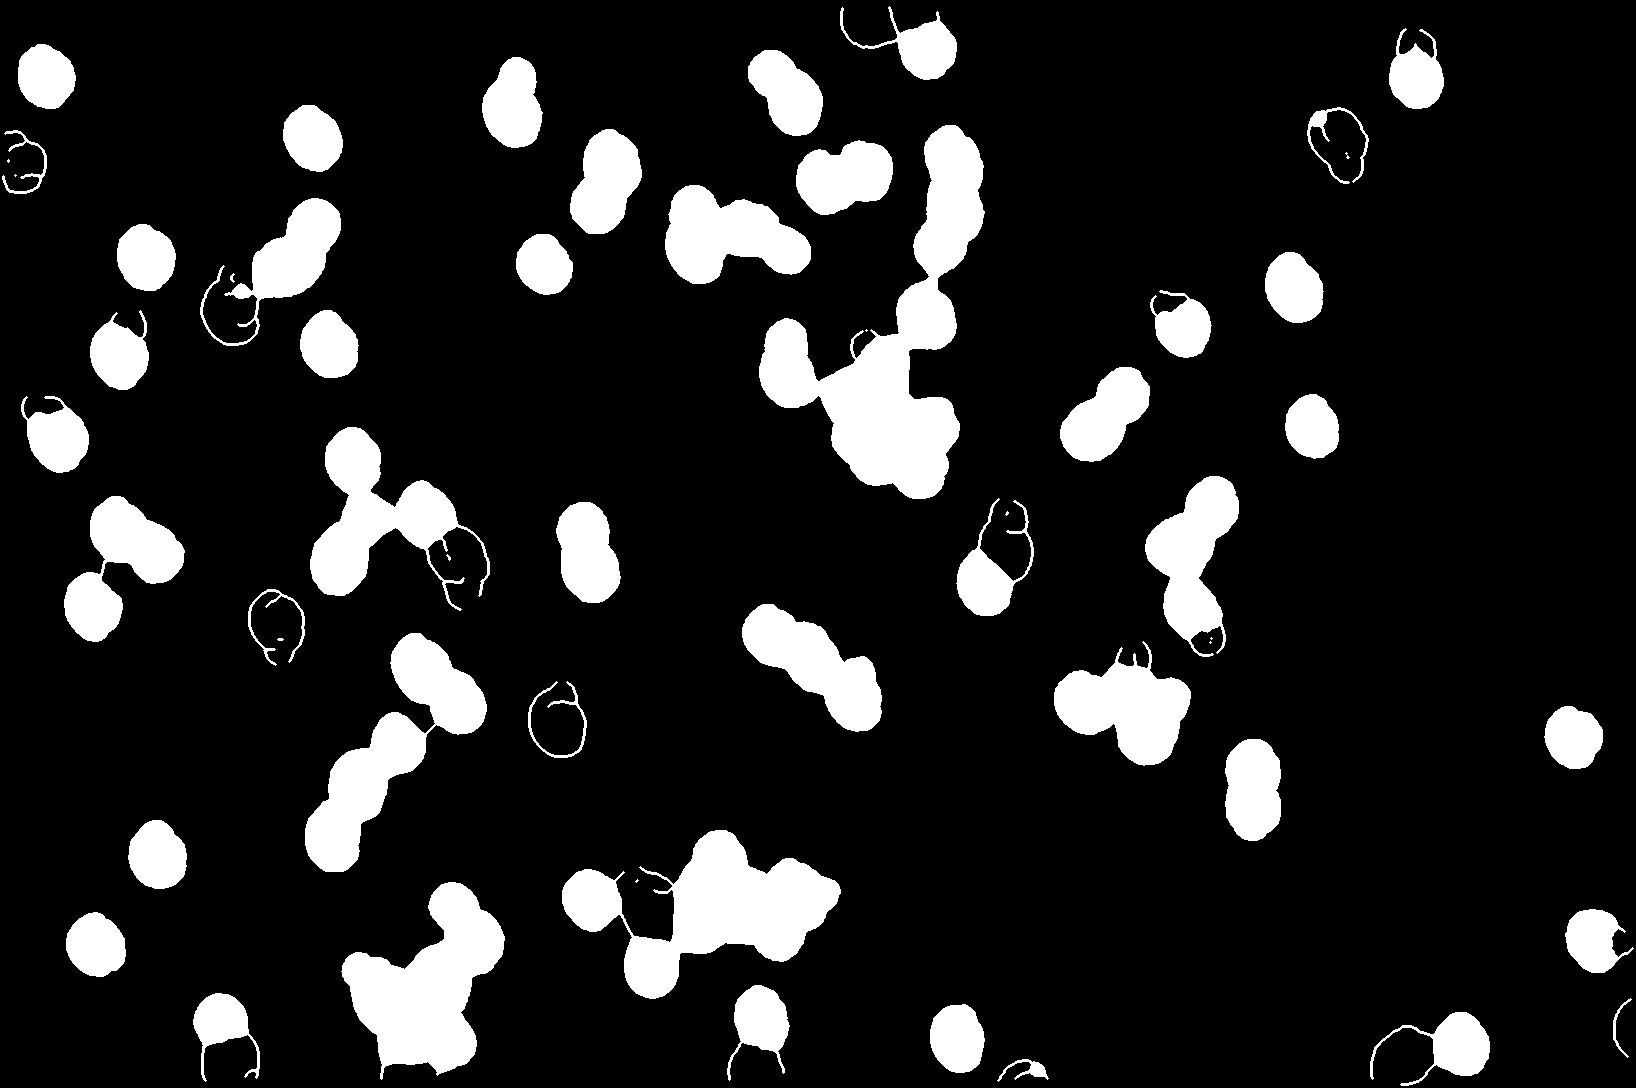

In [88]:
from scipy import ndimage
filled = ndimage.binary_fill_holes(sk_close).astype("uint8")
show(filled*255)

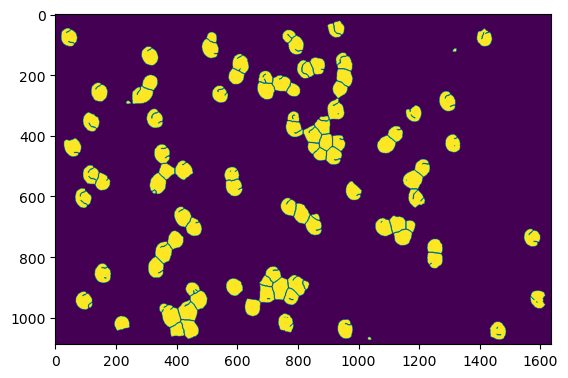

In [89]:
diff = filled - sk_close
plt.imshow(diff)

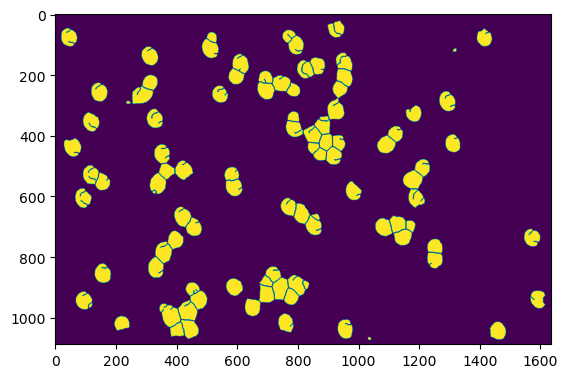

In [90]:
filled2= ndimage.binary_fill_holes(diff).astype("uint8")
plt.imshow(filled2)

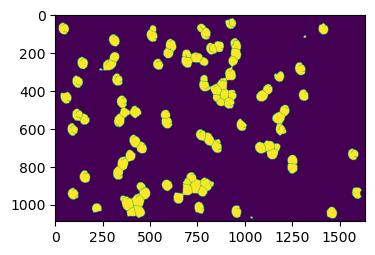

In [91]:
# 確実に背景である領域を求める
# 対象（白）の領域を膨張させるということは、残った黒の背景は「確実に背景」
sure_bg = ndimage.binary_dilation(filled2, iterations= 1).astype(filled2.dtype)
plt.figure(figsize=(4,4))
plt.imshow(sure_bg)

距離変換で得られた値の最小値と最大値: 0.0 27.978241
閾値（距離変換で得られた値の最大値×0.1）: 0.0
float32


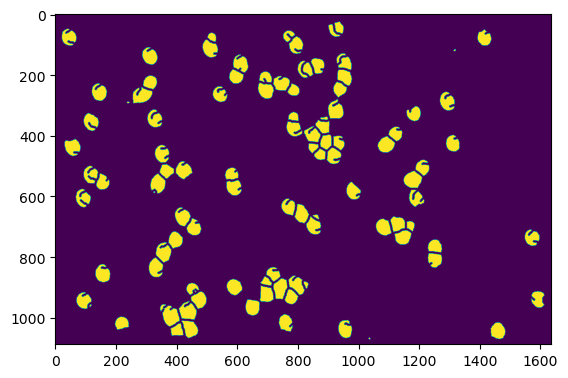

In [92]:
dist_transform = cv2.distanceTransform(filled2, cv2.DIST_L2, 5)
ratio = 0.1
print("距離変換で得られた値の最小値と最大値:", dist_transform.min(), dist_transform.max())
print(f'閾値（距離変換で得られた値の最大値×{ratio}）:',ratio*dist_transform.min())
ret, sure_fg = cv2.threshold(dist_transform, ratio*dist_transform.max(),255,0)
plt.imshow(sure_fg)
print(sure_fg.dtype)

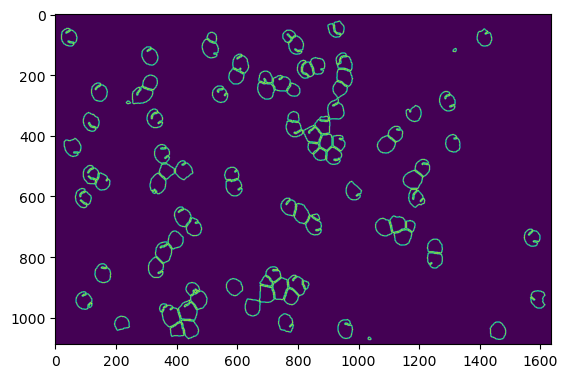

In [93]:
# Finding unknown region
# 背景でも前景でもないunknownな領域の情報」を取得
# 「絶対に背景」から「絶対に前景」の情報を引く
sure_fg = np.uint8(sure_fg)
sure_bg = np.uint8(sure_bg)
unknown = cv2.subtract(sure_bg, sure_fg)
plt.imshow(unknown*255)

In [94]:
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers+1
markers[unknown == 1] = 0 # boolean indexing
# この時点での背景のピクセル値 -> 1、各オブジェクトのピクセル値 -> 2,3,...,38, unknownのピクセル値 -> 0

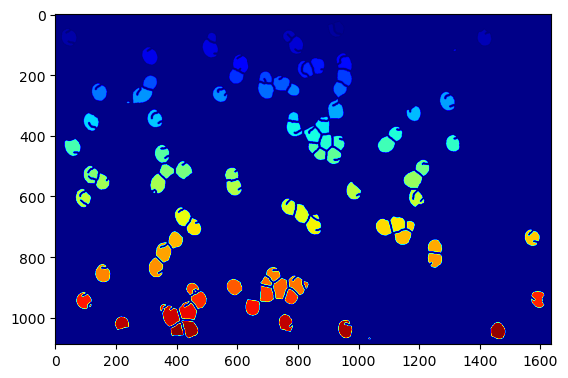

In [95]:
plt.imshow(markers, cmap = "jet")

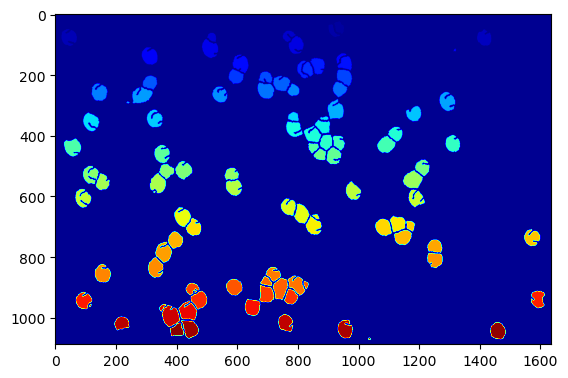

In [96]:
# Watershed関数による処理
path = "images/yeast_phase_x100.tif"
img_rgb = cv2.imread(path, 1)
markers = cv2.watershed(img_rgb, markers) # imgはRGBである必要がある
# この時点での背景のピクセル値 -> 1、境界領域 -> -1, 各オブジェクト -> 2,3,...,38,
plt.imshow(markers, cmap = "jet")

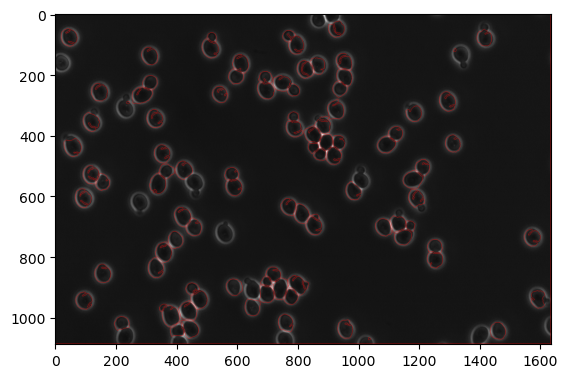

In [97]:
# 境界領域を赤色にする
img1_1 = img_as_ubyte(img0)
img_rgb_segm = cv2.cvtColor(img1_1, cv2.COLOR_GRAY2RGB)
img_rgb_segm[markers == -1] = (255, 0, 0)
plt.imshow(img_rgb_segm)